In [1]:
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
import imblearn.over_sampling
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
df_X = pd.read_csv('instacart_df_X_final2.csv')

In [3]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

    return X_tr, X_te, y_tr, y_te, df_tr

# Train Model using random seed of 42

In [4]:
#Step by step RMSEs, with .1 learning rate:
#best max_depth: 8 0.438
#best subsample: 0.7 0.438
#best min_child_weight: 10 0.438
#best colsample_bytree: 0.8 0.438
#With learning_rate set to 0.1 0.438

X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

gbm = xgb.XGBClassifier(
                        n_estimators=30000, #arbitrary large number
                        max_depth=8,
                        objective="binary:logistic",
                        learning_rate=.1, 
                        subsample=0.7,
                        min_child_weight=10,
                        colsample_bytree=0.8,
                       )

eval_set=[(X_tr,y_tr),(X_te,y_te)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_tr, y_tr, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=50,
                    verbose=False
                   )

f1_score(y_te, gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit)) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.27984133131476724

In [5]:
model_te_probs = gbm.predict_proba(X_te, ntree_limit=gbm.best_ntree_limit)[:,1] # positive class probs, same basic logistic model we fit in section 2 
thresh_ps = np.linspace(.10,.50,1000)
f1_scores = []
for p in thresh_ps:
    model_te_labels = model_te_probs >= p
    f1_scores.append(f1_score(model_te_labels, y_te))

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Boosting Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Boosting Model best F1 score 0.440 at prob decision threshold >= 0.210


# Score against my holdout

In [4]:
X_tr, X_h, y_tr, y_h, df_tr = get_user_split_data(df_X)
X_tr, X_te, y_tr, y_te, _ = get_user_split_data(df_tr)

In [4]:
with open('gbm_seed42.pkl', 'rb') as picklefile:
    gbm = pickle.load(picklefile)

In [7]:
model_h_probs = gbm.predict_proba(X_h, ntree_limit=gbm.best_ntree_limit)[:,1] # positive class probs, same basic logistic model we fit in section 2 
model_h_labels = model_h_probs >= 0.210
f1_score(model_h_labels, y_h)


# print('Boosting Model best F1 score %.3f at prob decision threshold >= %.3f' 
#       % (best_f1_score, best_thresh_p))

0.43952333102897073

Text(0.5,1,'Feature Importance')

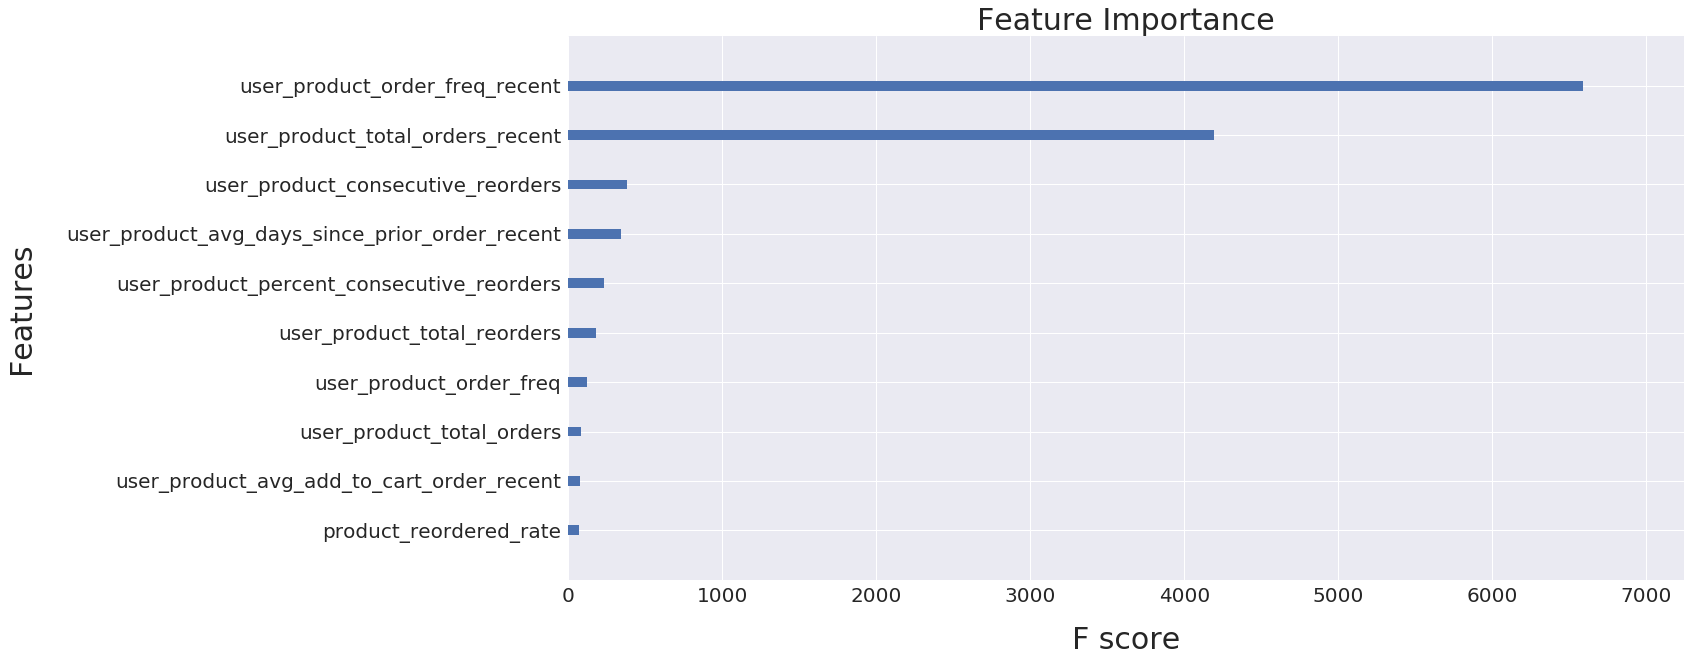

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(gbm, importance_type='gain', ax=ax, show_values=False, max_num_features=10)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.ylabel('Features', fontsize=30, labelpad=30)
plt.xlabel('F score', fontsize=30, labelpad=20)
plt.title('Feature Importance', fontsize=30)

In [7]:
gbm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=10, missing=None, n_estimators=30000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [6]:
with open('gbm_seed42.pkl', 'wb') as picklefile:
    pickle.dump(gbm, picklefile)

In [5]:
y_all= df_X['in_cart']
X_all = df_X.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 

In [6]:
model_all_probs = gbm.predict_proba(X_all, ntree_limit=gbm.best_ntree_limit)[:,1]
model_all_labels = model_all_probs >= 0.211
f1_score(model_all_labels, y_all)

0.43584332528872594

In [7]:
with open('model_all_probs_seed42.pkl', 'wb') as picklefile:
    pickle.dump(model_all_probs, picklefile)

with open('model_all_labels_seed42.pkl', 'wb') as picklefile:
    pickle.dump(model_all_labels, picklefile)

In [8]:
df_X['probs_from_model'] = model_all_probs

In [13]:
df_X['reordered_from_model'] = model_all_labels.astype(int)

In [15]:
df_X = df_X.drop(columns=['probs_from_model','reordered_from_model'])